# Air Quality Foreasting ($CO_2$ emissions) 
## **Business Objective:**
## To forecast $CO_2$ levels for an organization so that the organization can follow government norms with respects to $CO_2$ emission levels.
### Prepare a ppt for each step taken like EDA, Feature Engineering, Model Building,  Model Evaluation and Predicition table, and Deployment. Explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

## Model Building Phase On Raw data

### Importing the libraries required

In [1]:
# Importing 
# Libraries
import dtale

import warnings
import itertools
%matplotlib inline
import numpy as np
import pandas as pd

from math import sqrt
import seaborn as sns

import missingno as mn
import plotly.io as pio
sns.set_style('darkgrid')

from pandas import Grouper
import scipy.stats as stat
import plotly.express as px
from pandas import DataFrame

import statsmodels.api as smf
import pandas_profiling as pp
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from collections import Counter
import plotly.graph_objects as go
import plotly.figure_factory as ff

from pandas.plotting import lag_plot
import statsmodels.formula.api as sm
from plotly.offline import plot as off
from plotly.subplots import make_subplots

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.feature_selection import SelectKBest
from pandas_visual_analysis import VisualAnalysis
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES

from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from dataprep.eda import plot, plot_correlation, plot_missing, create_report

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale, RobustScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV

In [2]:
data=pd.read_excel('C:/Users\Moin Dalvi\Documents\Data Science Material\Projects\Air Quality Forecasting/CO2 dataset.xlsx'\
                   ,index_col='Year',parse_dates=True)

#data.set_index('Year', inplace=True)
data.index = pd.DatetimeIndex(data.index.values,freq=data.index.inferred_freq)
data.head()

CO2
1800-01-01  0.00568
1801-01-01  0.00561
1802-01-01  0.00555
1803-01-01  0.00548
1804-01-01  0.00542

In [3]:
upsampled_month = data.copy()
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(13))

                CO2
1800-01-31  0.00568
1800-02-28      NaN
1800-03-31      NaN
1800-04-30      NaN
1800-05-31      NaN
1800-06-30      NaN
1800-07-31      NaN
1800-08-31      NaN
1800-09-30      NaN
1800-10-31      NaN
1800-11-30      NaN
1800-12-31      NaN
1801-01-31  0.00561


In [4]:
interpolated_month = upsampled_month.interpolate(method='linear') 
print(interpolated_month.head(15))
interpolated_month.plot(figsize=(16,6))
plt.title("Interpolation uisng Linear Method", fontsize =  14)
plt.show()

                 CO2
1800-01-31  0.005680
1800-02-28  0.005674
1800-03-31  0.005668
1800-04-30  0.005662
1800-05-31  0.005657
1800-06-30  0.005651
1800-07-31  0.005645
1800-08-31  0.005639
1800-09-30  0.005633
1800-10-31  0.005628
1800-11-30  0.005622
1800-12-31  0.005616
1801-01-31  0.005610
1801-02-28  0.005605
1801-03-31  0.005600


In [5]:
interpolated_month.duplicated(keep=False).sum()

704

In [6]:
df = interpolated_month[1080:]
df

CO2
1890-01-31   2.530000
1890-02-28   2.553333
1890-03-31   2.576667
1890-04-30   2.600000
1890-05-31   2.623333
...               ...
2013-09-30  14.966667
2013-10-31  15.000000
2013-11-30  15.033333
2013-12-31  15.066667
2014-01-31  15.100000

[1489 rows x 1 columns]

### Splitting Train and Test Data on Original data 

#### Leaving Test Data with 15 Years of Time Series
+ **Training Data** = Fit the model only to training period. 
+ **Testing Data** = Assess the model performance on Testing. 
+ **Deploy model by training on whole dataset. No random partition That’s because the order sequence of the time series should be intact in order to use it for forecasting.**

In [13]:
train_len = -169
train_data = df[:train_len]
test_data = df[train_len:]

In [14]:
train_data

CO2
1890-01-31   2.530000
1890-02-28   2.553333
1890-03-31   2.576667
1890-04-30   2.600000
1890-05-31   2.623333
...               ...
1999-08-31  17.191667
1999-09-30  17.233333
1999-10-31  17.275000
1999-11-30  17.316667
1999-12-31  17.358333

[1320 rows x 1 columns]

In [15]:
train_data.shape

(1320, 1)

In [16]:
test_data

CO2
2000-01-31  17.400000
2000-02-29  17.366667
2000-03-31  17.333333
2000-04-30  17.300000
2000-05-31  17.266667
...               ...
2013-09-30  14.966667
2013-10-31  15.000000
2013-11-30  15.033333
2013-12-31  15.066667
2014-01-31  15.100000

[169 rows x 1 columns]

In [42]:
test_data.shape

(121, 1)

### We are going to forecast for the last 15 years. that is from 2000 to 2014.

##### Last 169 records contain data from 2000 to 2014 data.

In [18]:
%matplotlib inline

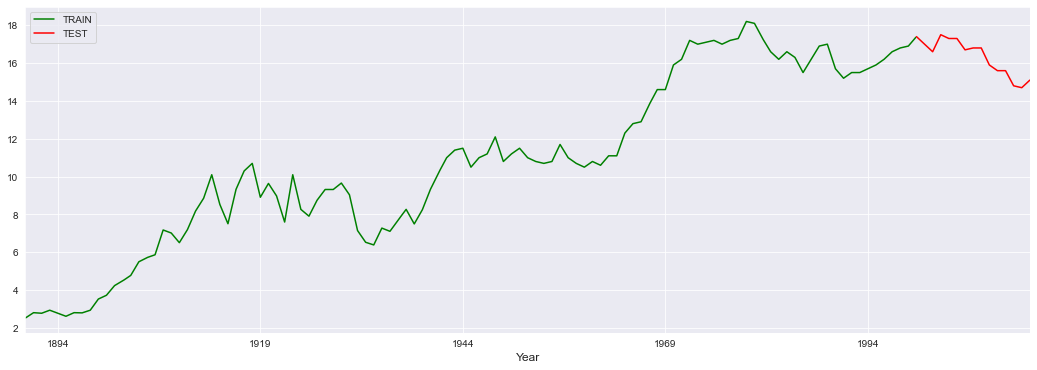

In [19]:
train_data.CO2.plot(legend=True,label='TRAIN',color='green')
test_data.CO2.plot(legend=True,label='TEST', figsize=(18,6),color='red')
plt.xlabel('Year', fontsize= 12)
plt.legend()
plt.show()

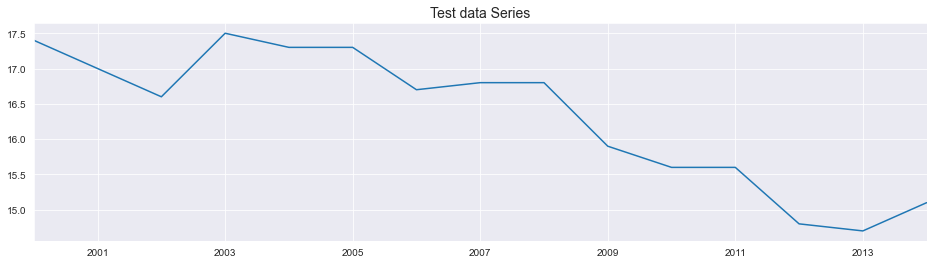

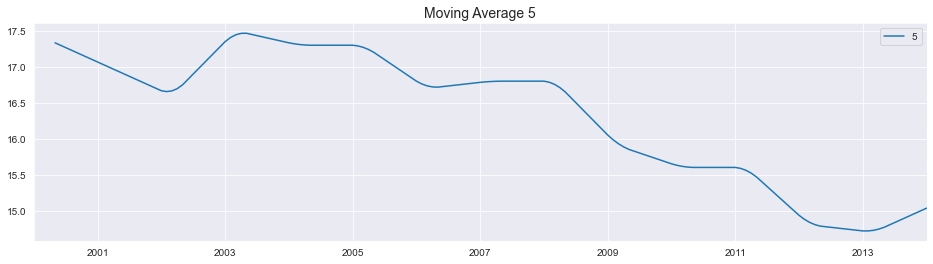

In [20]:
plt.figure(figsize=(16,4))
test_data.CO2.plot(label="org")
plt.title("Test data Series", fontsize=14)
plt.figure(figsize=(16,4))
test_data["CO2"].rolling(5).mean().plot(label=str(5))
plt.title("Moving Average "+str(5), fontsize=14)
plt.legend(loc='best')
plt.show()

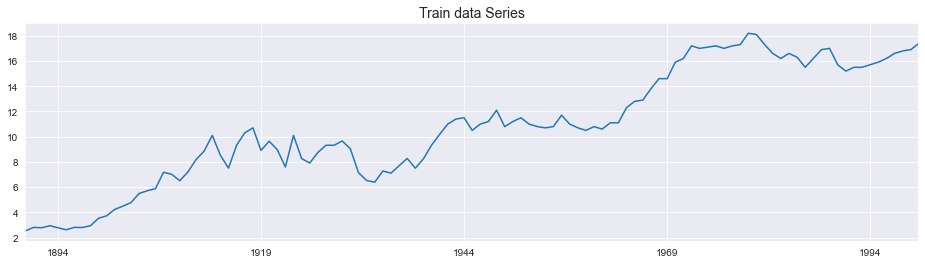

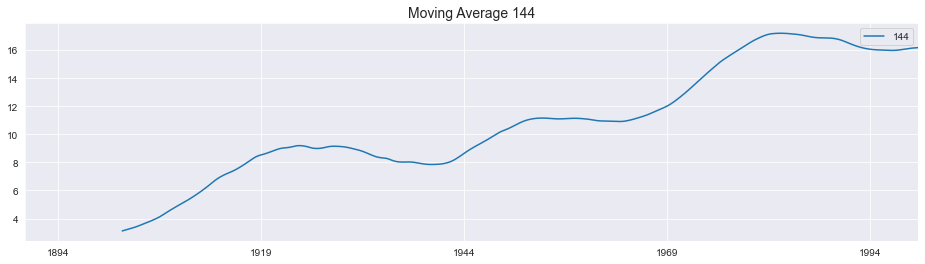

In [21]:
plt.figure(figsize=(16,4))
train_data.CO2.plot(label="org")
plt.title("Train data Series", fontsize=14)
plt.figure(figsize=(16,4))
train_data["CO2"].rolling(144).mean().plot(label=str(144))
plt.title("Moving Average "+str(144), fontsize=14)
plt.legend(loc='best')
plt.show()

### Evaluation Metric MAPE

In [22]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

## Model Building

___
## Exponential Methods
### Simple Exponential Method

#### Using Forecast Attribute

In [23]:
ses_model = SimpleExpSmoothing(train_data['CO2']).fit(optimized=True)
test_pred_ses = ses_model.forecast(169)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.CO2))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.CO2)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 6.5840423114011655 
 Train Root Mean Squared Error = 0.06181026941475095 
 Test Root Mean Squared Error = 1.3570279658589974


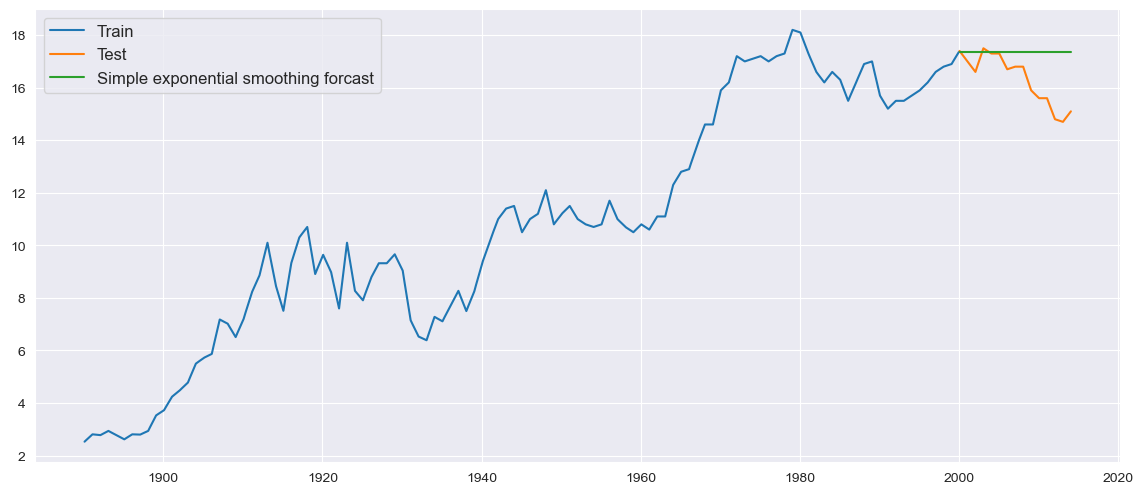

In [24]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. **This method doesn't captures seasonality.**

---
### Holt method (Double Exponential) 

##### Captures both Level and Trend .

In [25]:
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(169)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.CO2))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.CO2)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 28.9055050657707 
 Train Root Mean Squared Error = 0.025412878653115763 
 Test Root Mean Squared Error = 5.384533347970685


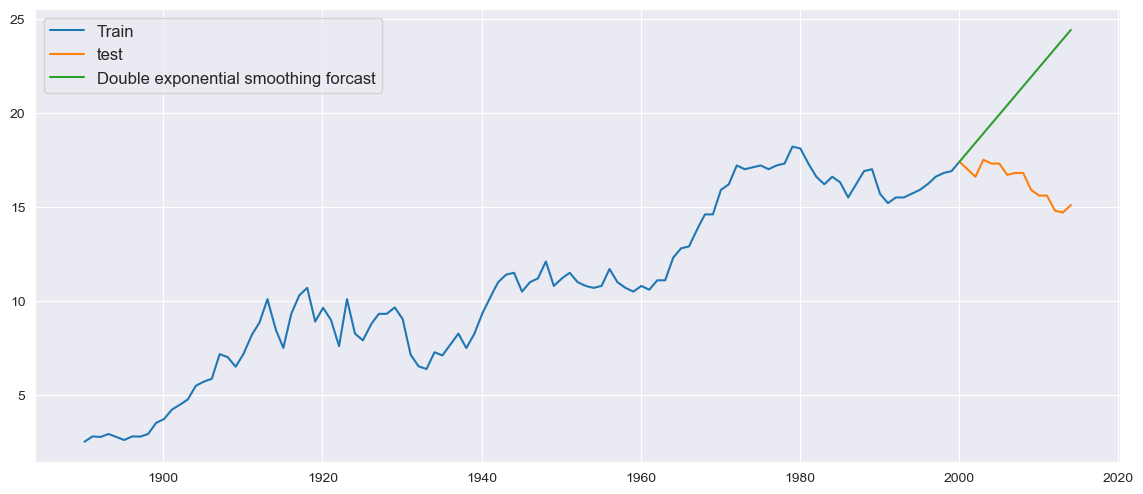

In [26]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. We can see that we are able to capture the trend of the data.
2. We were not able to capture the seasonality.

### Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)

##### Captures Level, Trend and Seasonality.

In [27]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(169)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.CO2))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.CO2)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 28.93016230545598 
 Train Root Mean Squared Error = 0.025412840377591752 
 Test Root Mean Squared Error = 5.388985463115392


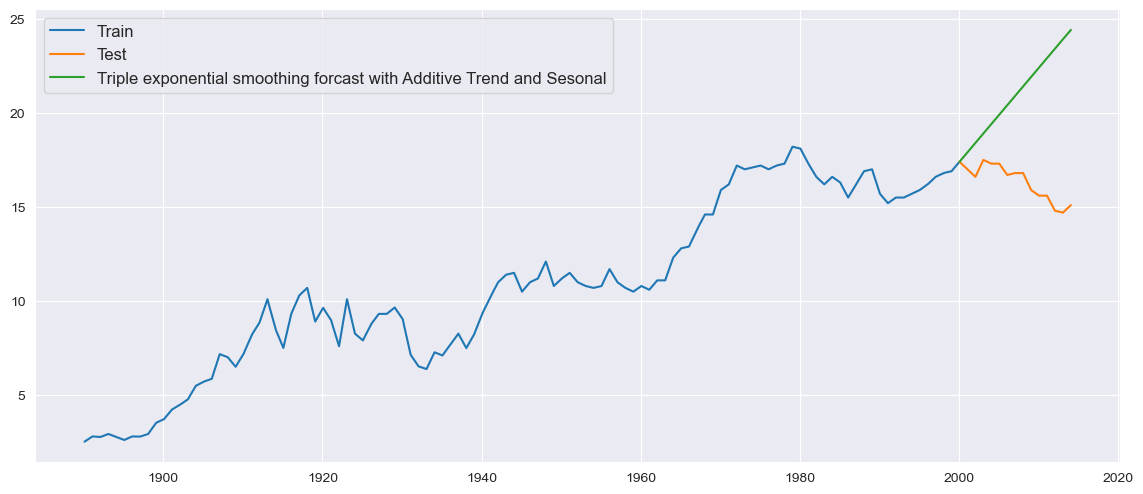

In [28]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. It captures the trend, but which we can see that the forecasted values are higher level than the test level.
2. It doesn't captures the seasonality.

### Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)

In [29]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(169)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.CO2))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.CO2)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error = 28.181884563248328 
 Train Root Mean Squared Error = 0.0253974811091082 
 Test Root Mean Squared Error = 5.253746363774618


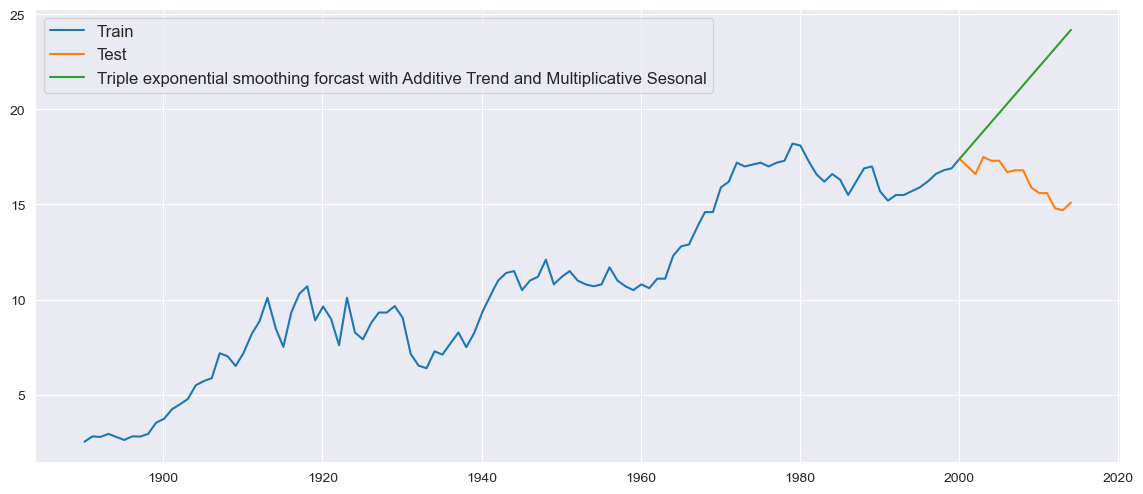

In [30]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. We can see that the errors have not reduced, we are not able to capture the seasonality.

### Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [31]:
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(169)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.CO2))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.CO2)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error = 32.11783142109215 
 Train Root Mean Squared Error = 0.02543686941723642 
 Test Root Mean Squared Error = 6.050709497257991


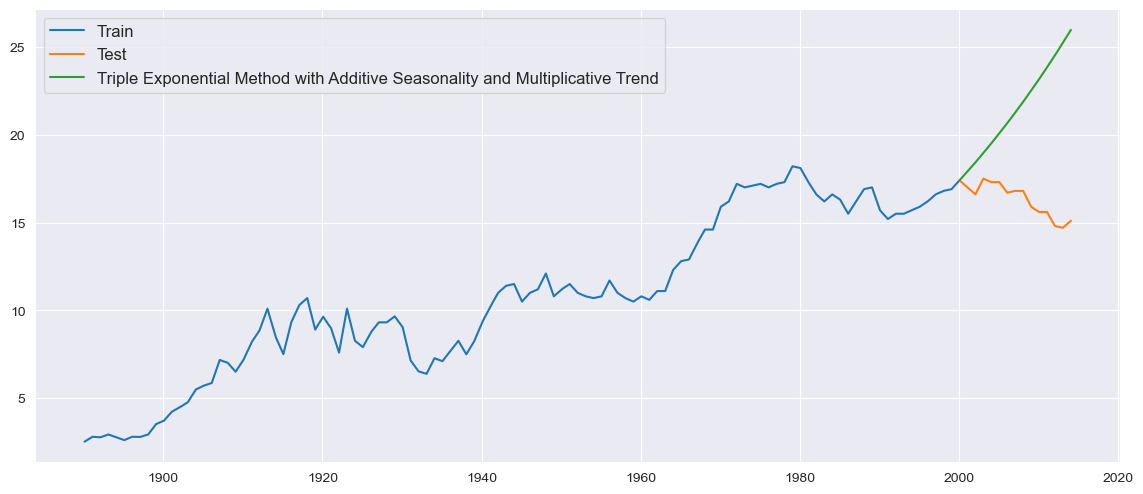

In [32]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best', fontsize=12)
plt.show()

### Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [33]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(169)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.CO2))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.CO2)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error = 31.022271862513023 
 Train Root Mean Squared Error = 0.025417469748960413 
 Test Root Mean Squared Error = 5.84611883020077


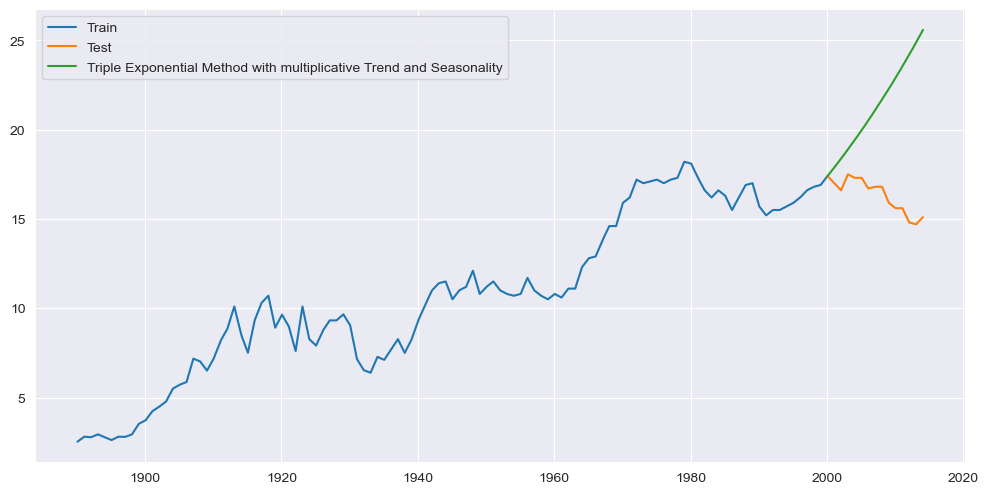

In [34]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

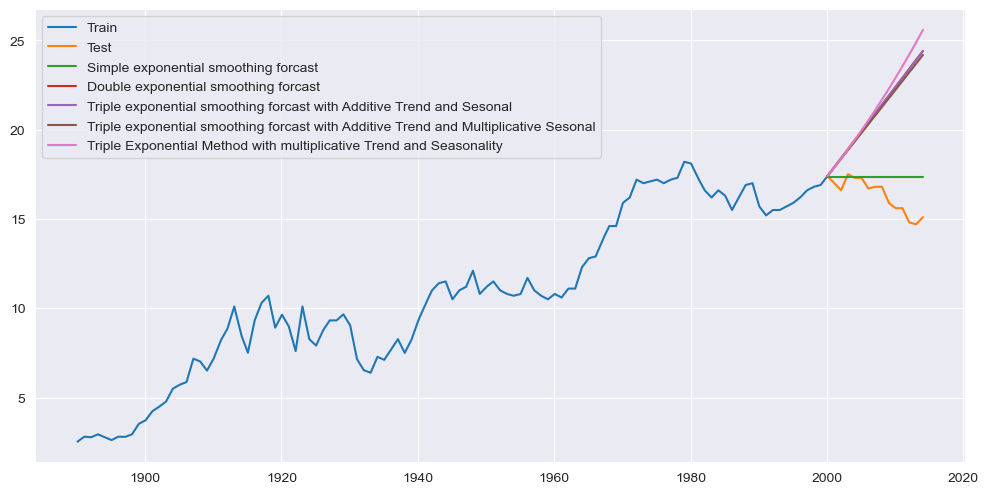

In [35]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

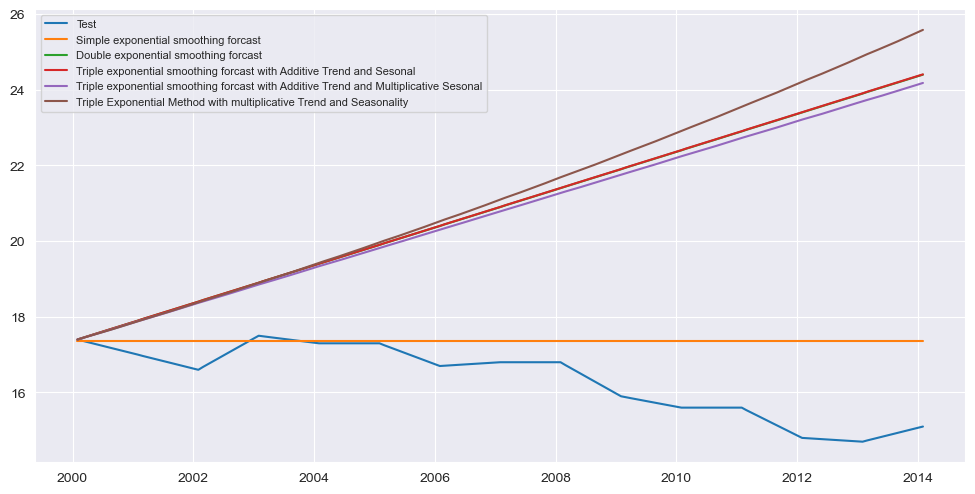

In [36]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best', fontsize=8)
plt.show()

In [37]:
#Comparing the results 

Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

Models  Train_RMSE  Test_MAPE(%)  Test_RMSE_Values
0         Simple_Exp    0.061810      6.584042          1.357028
1  Triple_Exp_mul_ad    0.025397     28.181885          5.253746
2         Double_Exp    0.025413     28.905505          5.384533
3      Triple_Exp_ad    0.025413     28.930162          5.388985
4     Triple_Exp_mul    0.025417     31.022272          5.846119
5  Triple_Exp_ad_mul    0.025437     32.117831          6.050709

### Visualizing Models Performance

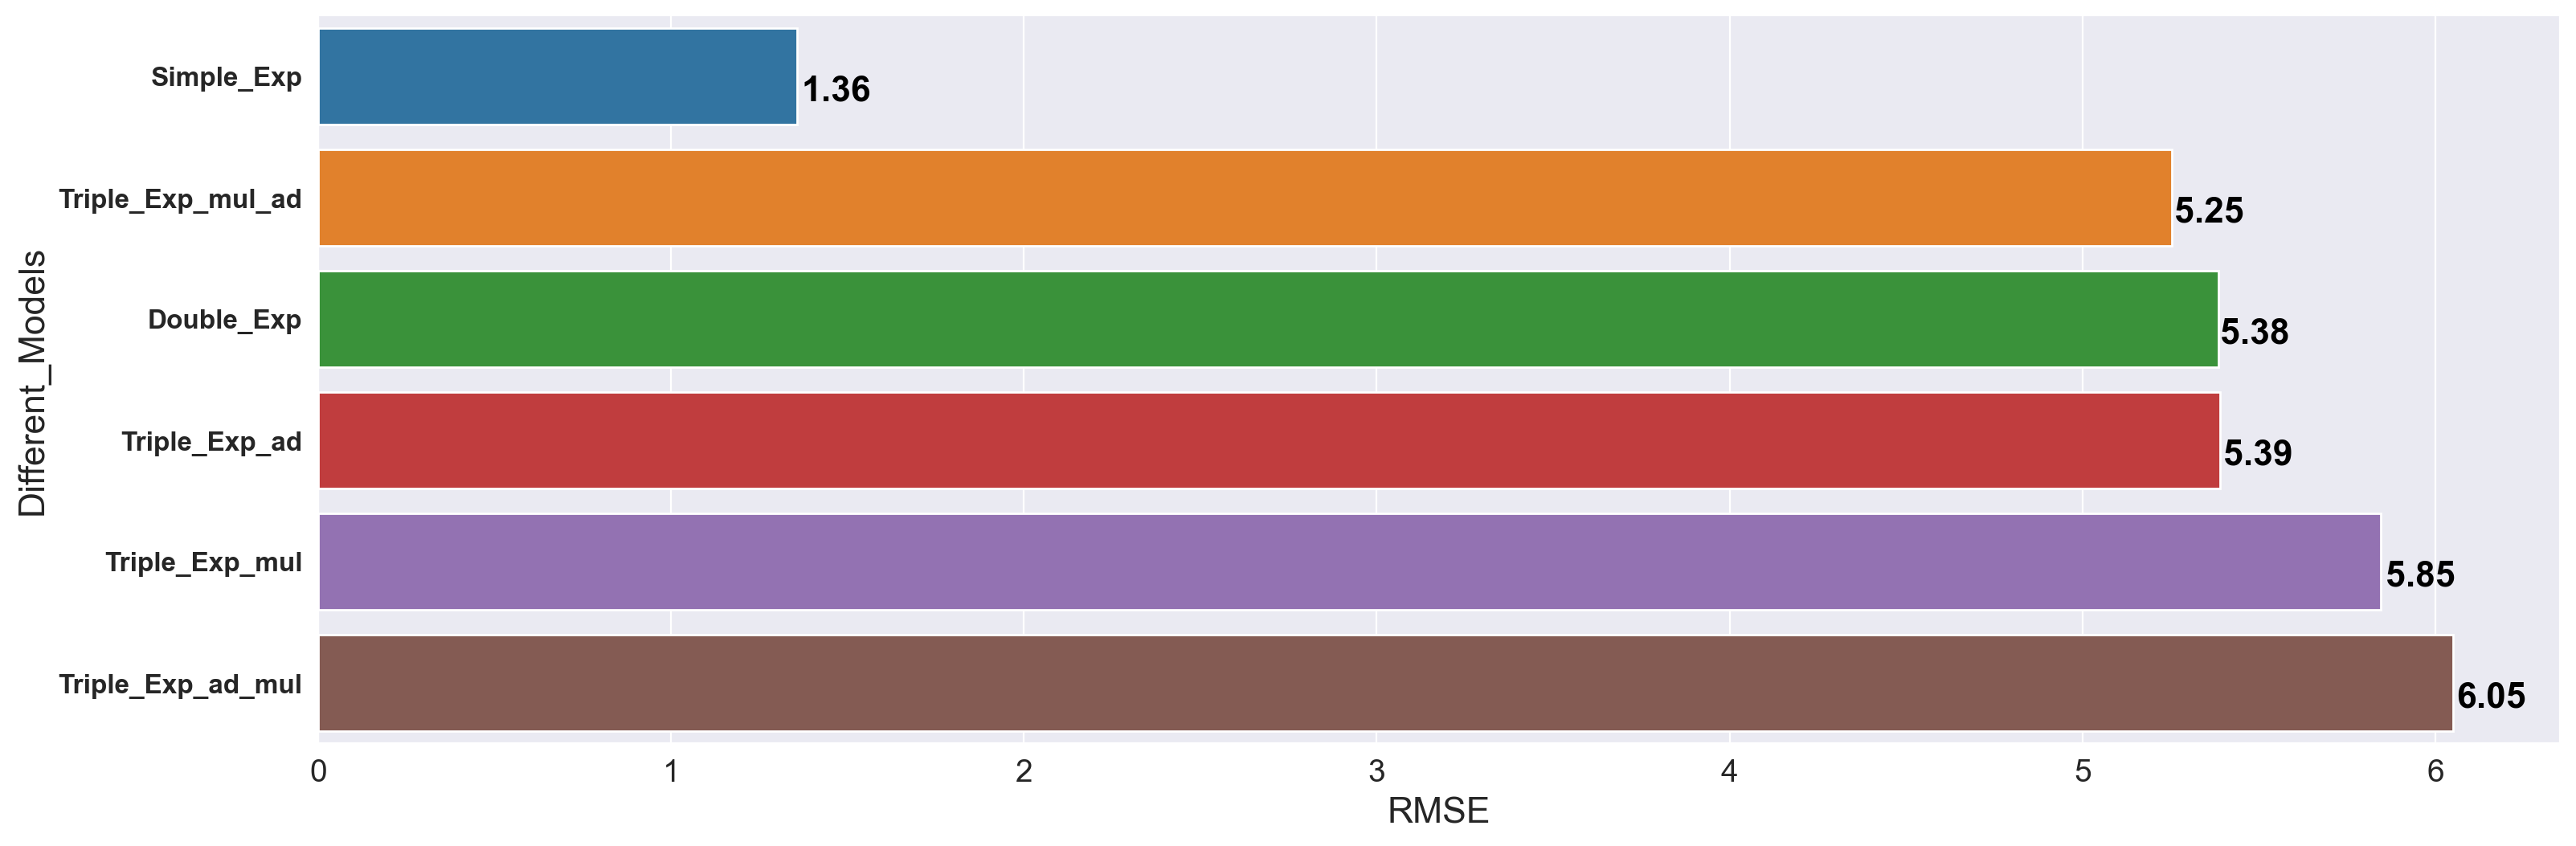

In [38]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=200)
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,2)):
    axe.text(v + 0.01, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

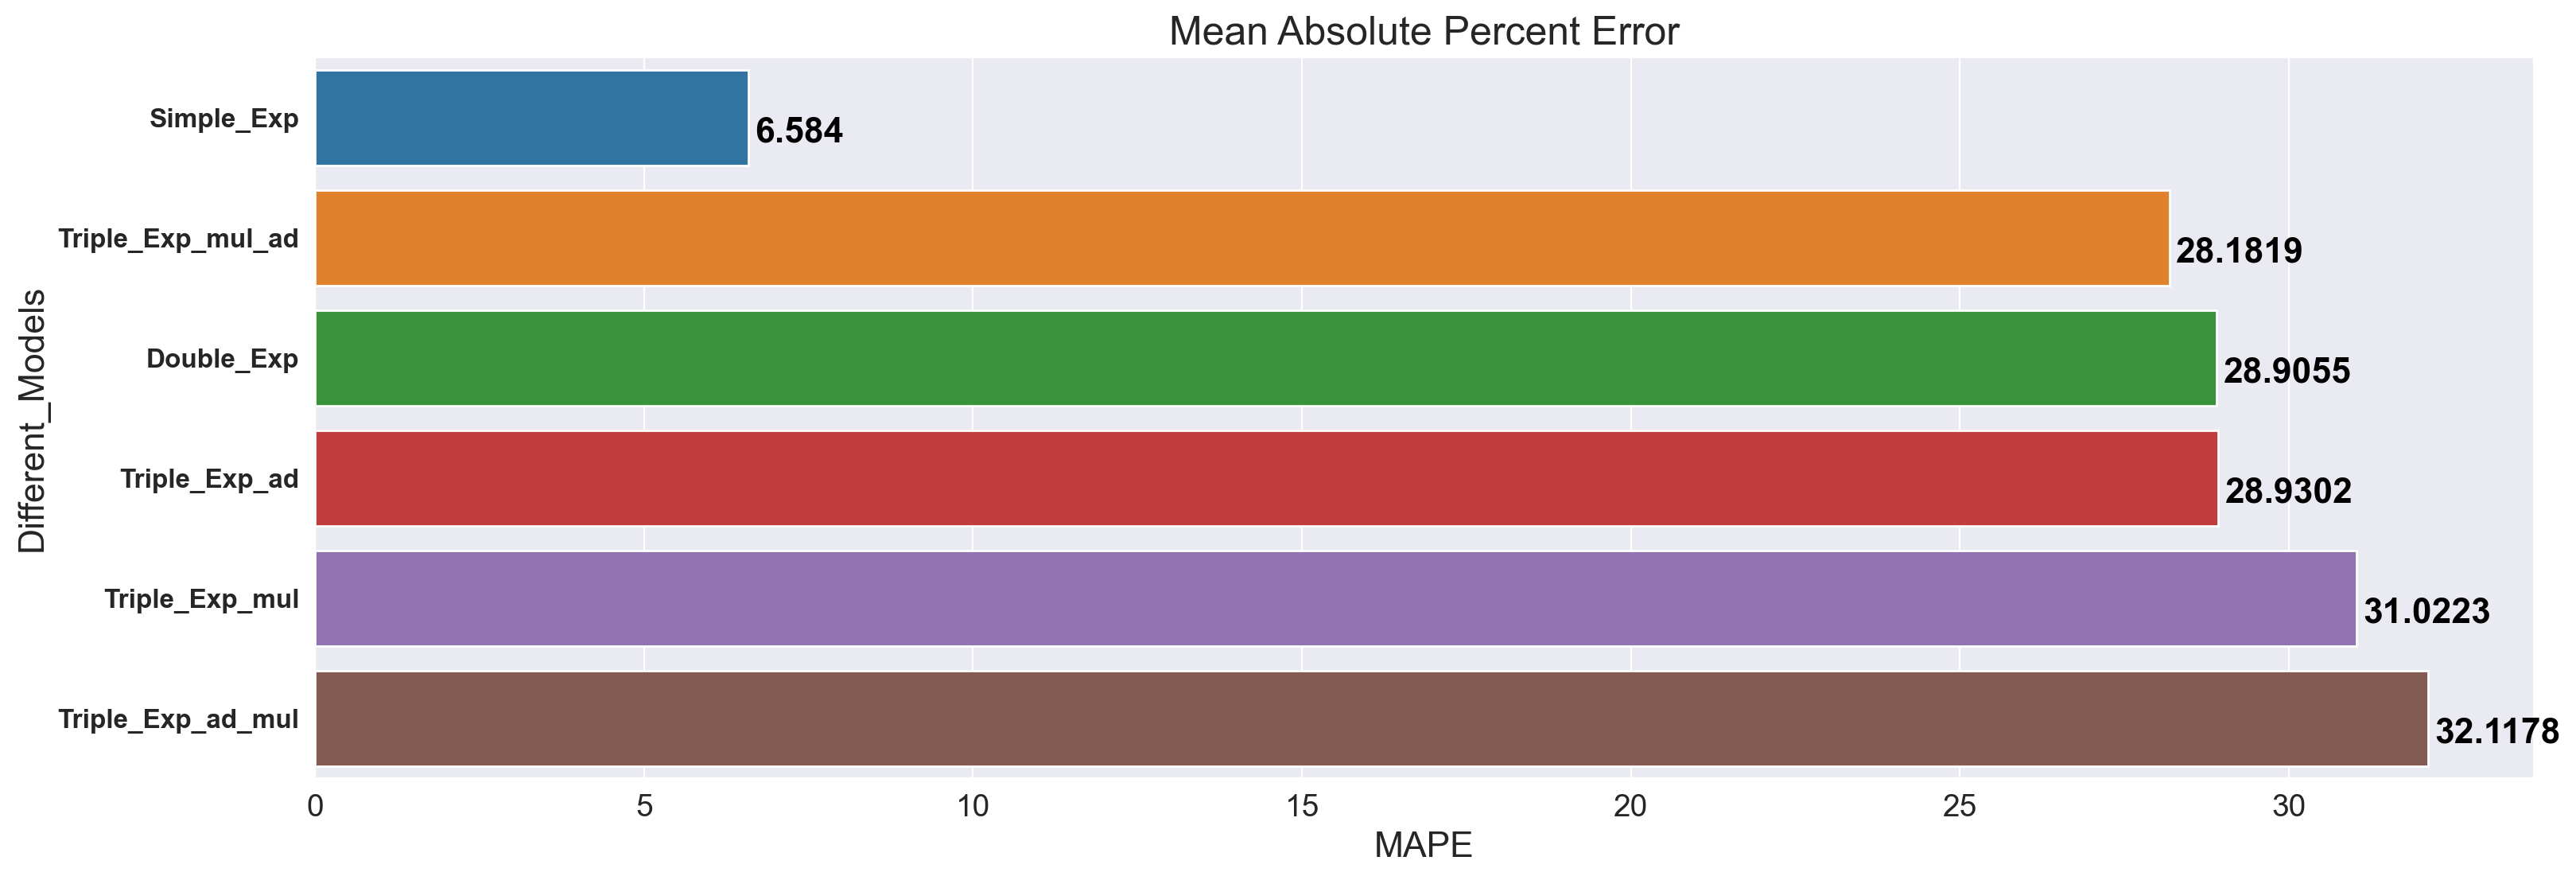

In [39]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=200)
sns.barplot(x='Test_MAPE(%)', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('MAPE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.title("Mean Absolute Percent Error", fontsize = 18)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation['Test_MAPE(%)'].values,4)):
    axe.text(v + 0.1, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

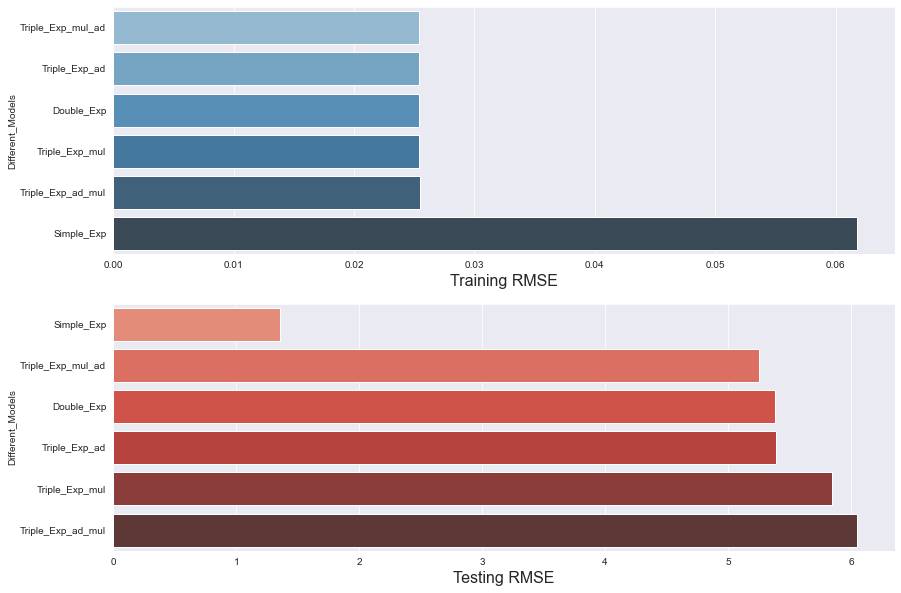

In [40]:
f, axes = plt.subplots(2,1, figsize=(14,10))
train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=True)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models')

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=True)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models')

plt.show()

# Autoregressive Integrated Moving Averages (ARIMA)

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

### Assumptions of ARIMA model
1. **Data should be stationary** – by stationary it means that the properties of the series doesn’t depend on the time when it is captured. A white noise series and series with cyclic behavior can also be considered as stationary series.
2. **Data should be univariate** – ARIMA works on a single variable. Auto-regression is all about regression with the past values.

#### Stationary vs Non-stationary Time Series

## ARIMA Hyperparameter Tuning

***order(p,d,q)***

p = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series.

d = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary.


q = This variable denotes the lag of the error component, where error component is a part of the time series not explained by trend or seasonality.

In [50]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [51]:
import itertools

In [52]:
p = range(0,8)
q = range(0,8)
d = range(0,5)

In [53]:
pqd_combination = list(itertools.product(p,d,q))

In [54]:
len(pqd_combination)

320

In [55]:
rmse = []
order = []

In [56]:
for pdq in pqd_combination:
    try:
        model = ARIMA(train_data, order=pdq).fit()
        pred = model.forecast(169)
        error = np.sqrt(mean_squared_error(test_data,pred))
        order.append(pdq)
        rmse.append(error)
    except:
        continue

In [57]:
value_pqd = pd.DataFrame(index=order,data=rmse,columns=['rmse'])
value_pqd.sort_values('rmse')

rmse
(3, 0, 7)   0.450840
(3, 0, 1)   0.491076
(2, 0, 0)   0.495073
(6, 0, 6)   0.497923
(5, 0, 6)   0.520820
...              ...
(6, 4, 6)  35.372214
(3, 4, 2)  43.908693
(4, 4, 4)  51.616991
(0, 4, 5)  54.225216
(5, 4, 4)  62.391396

[320 rows x 1 columns]

### ^Observation: After using Resampled dataset we got the best optimal values

In [59]:
arima_model = ARIMA(train_data, order=(3, 0, 7))
arima_model_fit = arima_model.fit()
y_hat_ar = df.copy()
y_hat_ar['arima_forecast'] = arima_model_fit.predict(start = df.index.min(), end = df.index.max())

In [60]:
%matplotlib inline

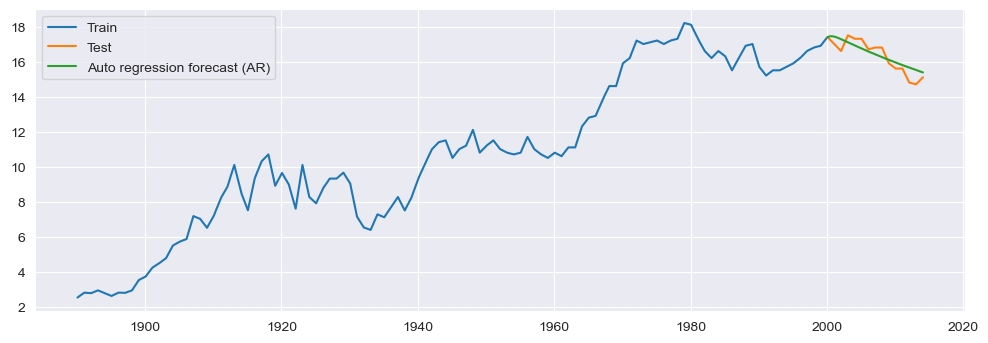

In [61]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train_data['CO2'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

#### Observation
1. We can see that we have done moderately well.
2. No Seasonality captured. Only Trend has been captured

### Model Evaluation

### Training Error

In [62]:
train_arima  = arima_model_fit.fittedvalues
train_rmse_arima  = sqrt(mean_squared_error(train_arima ,train_data))
train_rmse_arima

0.22821457289337788

### Testing Error

#### RMSE (Root Mean Squared Error)

In [63]:
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(3)
rmse_ARIMA

0.451

#### MAPE (Mean Absolute Percent Error)

In [64]:
mape_arima = round(np.mean(np.abs((test_data.CO2 - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.CO2)*100),3)
mape_arima

2.511

#### Observation
1. We can see that AR model has done reasonably good job but not better than Holt's method.
2. We souldn't compare it with Holt's method. Because Holt's method captures seasonality

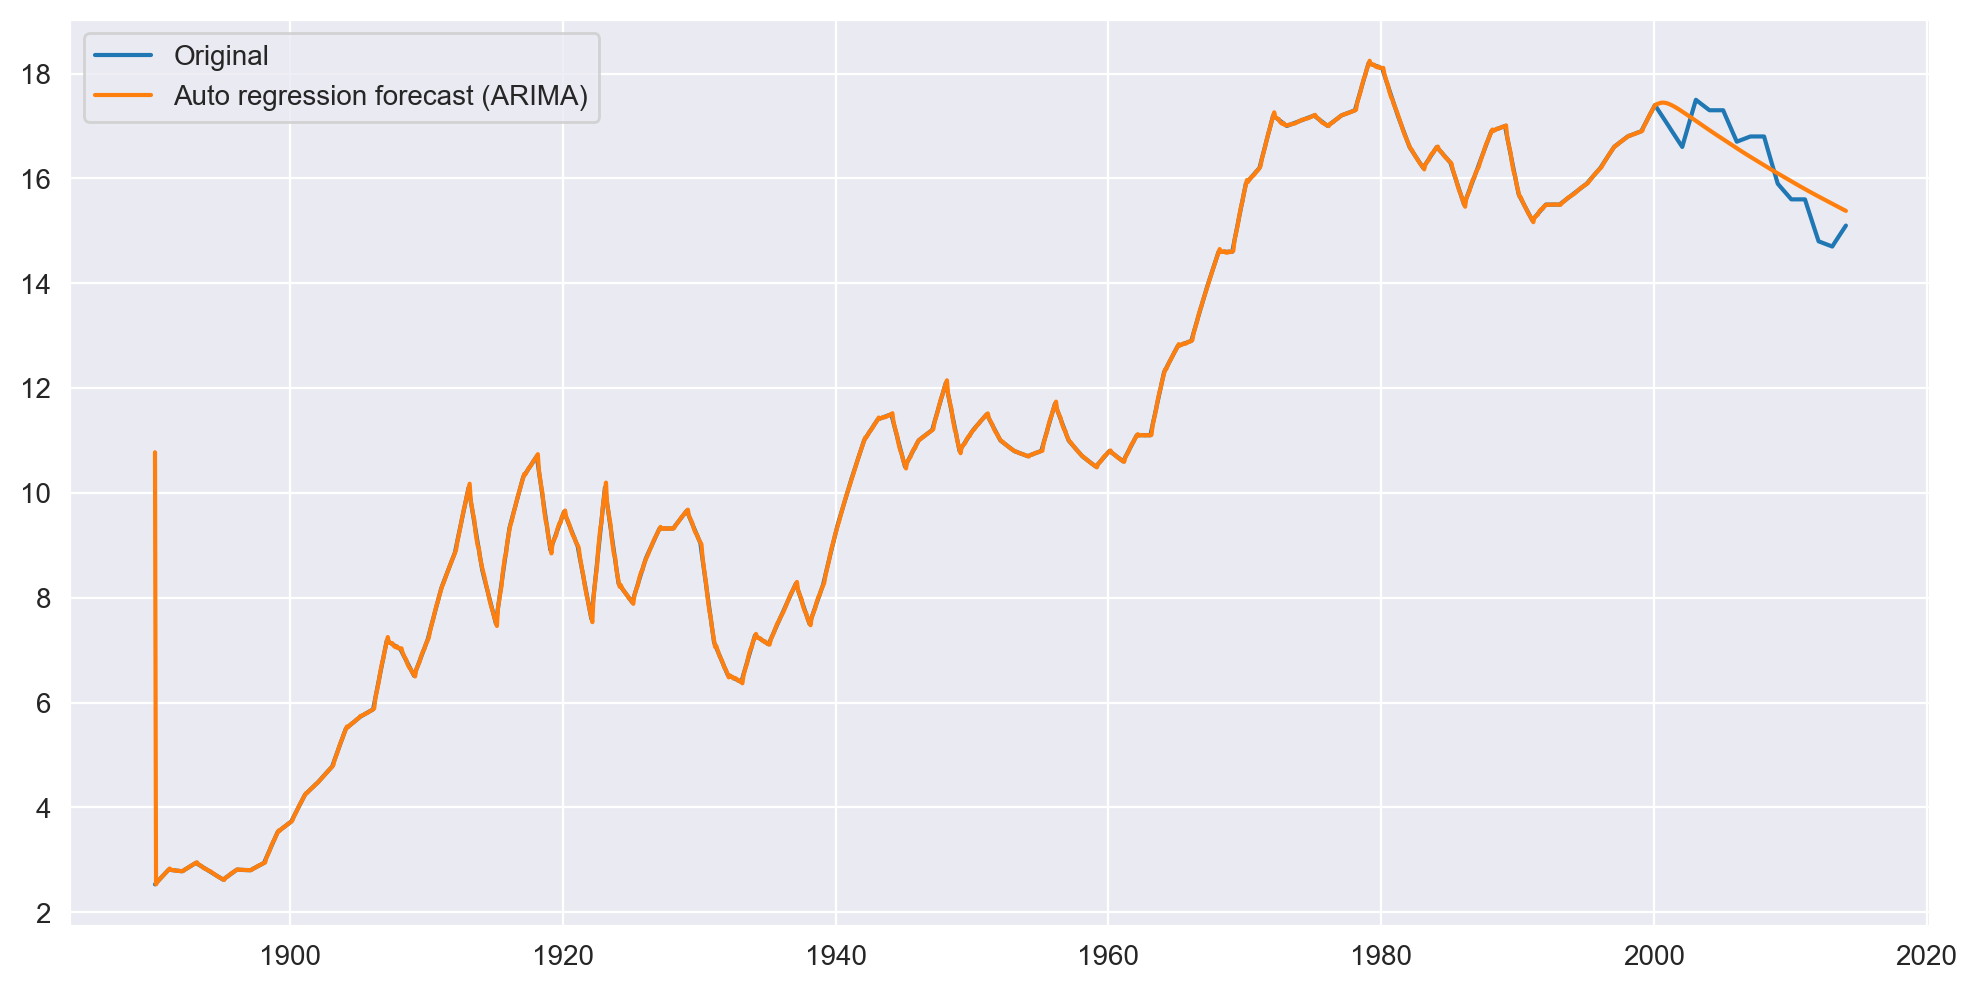

In [65]:
plt.figure(figsize=(12,6), dpi=200)
plt.plot(df['CO2'], label='Original')
plt.plot(y_hat_ar['arima_forecast'], label='Auto regression forecast (ARIMA)')
plt.legend(loc='best')
plt.show()

### Analysing the Residuals

##### The mean of the Residual should be zero or close to Zero

In [66]:
model_residual = arima_model_fit.resid
model_residual.mean()

-0.0054585095746395975

#### Residuals must be stationary

In [67]:
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [68]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


#### No autocorrelation between residuals

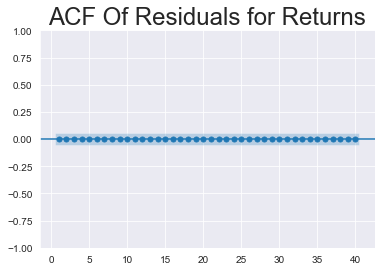

In [69]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

#### Residuals must be random

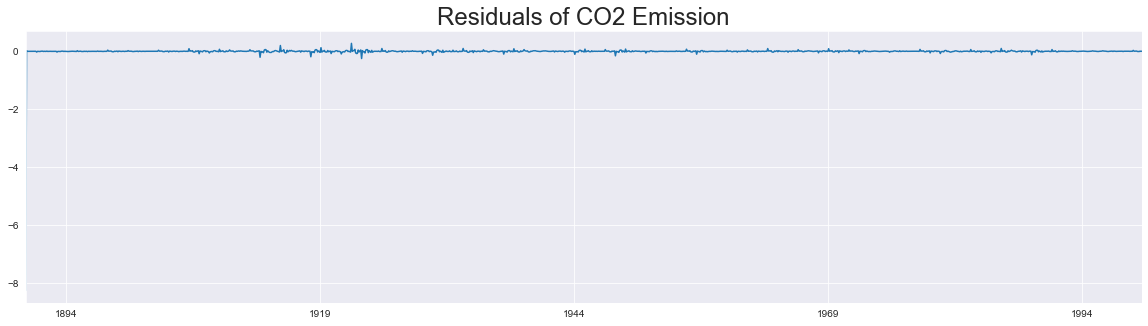

In [70]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of CO2 Emission", size=24)
plt.show()

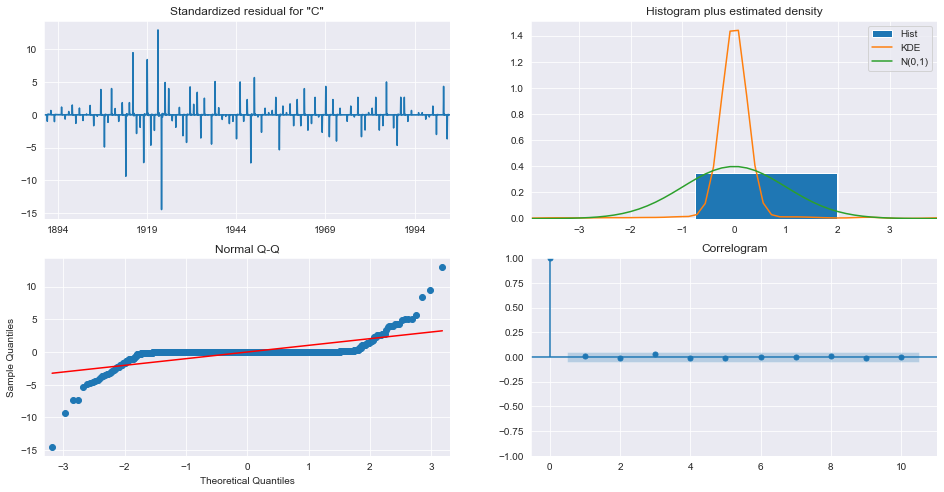

In [25]:
arima_model_fit.plot_diagnostics(figsize=(16,8))
plt.show()

In [71]:
y_hat_ar[test_data.index.min():]

CO2  arima_forecast
2000-01-31  17.400000       17.391205
2000-02-29  17.366667       17.409294
2000-03-31  17.333333       17.419918
2000-04-30  17.300000       17.427047
2000-05-31  17.266667       17.434746
...               ...             ...
2013-09-30  14.966667       15.424950
2013-10-31  15.000000       15.413785
2013-11-30  15.033333       15.402647
2013-12-31  15.066667       15.391535
2014-01-31  15.100000       15.380450

[169 rows x 2 columns]

In [72]:
y_hat_ar

CO2  arima_forecast
1890-01-31   2.530000       10.774376
1890-02-28   2.553333        2.530996
1890-03-31   2.576667        2.577048
1890-04-30   2.600000        2.600034
1890-05-31   2.623333        2.623592
...               ...             ...
2013-09-30  14.966667       15.424950
2013-10-31  15.000000       15.413785
2013-11-30  15.033333       15.402647
2013-12-31  15.066667       15.391535
2014-01-31  15.100000       15.380450

[1489 rows x 2 columns]

In [74]:
np.mean(APE.tail(20))

4.36131126759073

### Calculating Absolute Percent Error and Error<a class="anchor" id="7.3"></a>

In [76]:
# Computing the absolute percent error
APE=100*(abs(y_hat_ar['CO2']-y_hat_ar['arima_forecast'])/y_hat_ar['CO2'])
Error = (abs(y_hat_ar['CO2']-y_hat_ar['arima_forecast']))
print('The Accuracy for Test Data -- ARIMA model = {}%'.format(np.round(100-np.mean(APE.tail(169))),2))
print('The Mean Error for Test Data -- ARIMA model = ', np.mean((Error.tail(169))))

# adding absolute percent error to table
y_hat_ar['Error']=Error
y_hat_ar['Absolute Percent Error %']=APE

y_hat_ar.tail(121)

The Accuracy for Test Data -- ARIMA model = 97.0%
The Mean Error for Test Data -- ARIMA model =  0.4039056595424153


CO2  arima_forecast     Error  Absolute Percent Error %
2004-01-31  17.300000       16.920253  0.379747                  2.195067
2004-02-29  17.300000       16.905533  0.394467                  2.280153
2004-03-31  17.300000       16.890844  0.409156                  2.365063
2004-04-30  17.300000       16.876186  0.423814                  2.449793
2004-05-31  17.300000       16.861559  0.438441                  2.534341
...               ...             ...       ...                       ...
2013-09-30  14.966667       15.424950  0.458284                  3.062029
2013-10-31  15.000000       15.413785  0.413785                  2.758567
2013-11-30  15.033333       15.402647  0.369313                  2.456629
2013-12-31  15.066667       15.391535  0.324868                  2.156204
2014-01-31  15.100000       15.380450  0.280450                  1.857282

[121 rows x 4 columns]

[Table of Contents](#0.1)

### 7.4 Visualizing the Relationship between the Actual and Predicted ValuesModel Validation<a class="anchor" id="7.4"></a>

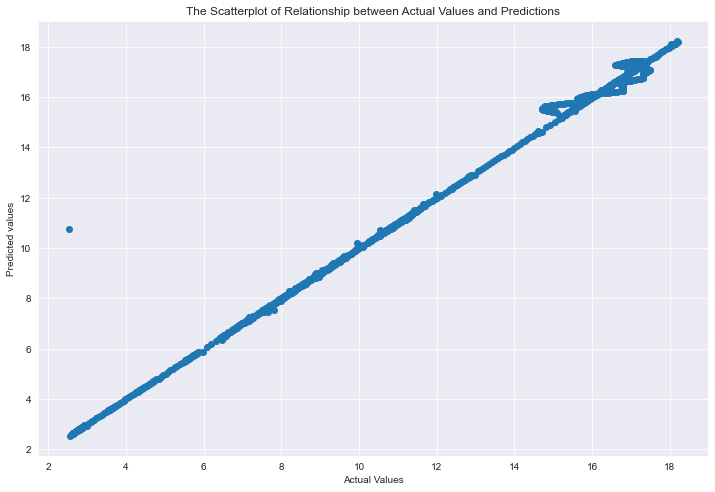

In [77]:
plt.figure(figsize=(12,8))
plt.xlabel("Actual Values")
plt.ylabel("Predicted values")
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.scatter(y_hat_ar['CO2'], y_hat_ar['arima_forecast'])

In [48]:
y_hat_ar.to_csv('C:/Users\Moin Dalvi\Documents\Data Science Material\Projects\Air Quality Forecasting/prediction.csv')

### Seasonal Auto Regressive Integrated Moving Average (SARIMA)
ARIMA with Seasonal component added.

In [78]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# We are only passing the Box Cox because the ARIMAX will perform the differencing internally
# seasonal_order P=1, Q=1, D=1 and m=12
# m=12 . Because the seasonality is monthly.

In [79]:
sarima_model = SARIMAX(train_data, order=(3, 0, 7), seasonal_order=(3, 0, 7,12))
sarima_model_fit= sarima_model.fit()

In [80]:
y_hat_sarima = df.copy()
y_hat_sarima['sarima_forecast'] = sarima_model_fit.predict(df.index.min(), df.index.max())

In [81]:
y_hat_sarima

CO2  sarima_forecast
1890-01-31   2.530000         0.000000
1890-02-28   2.553333         2.529939
1890-03-31   2.576667         2.572974
1890-04-30   2.600000         2.595467
1890-05-31   2.623333         2.618831
...               ...              ...
2013-09-30  14.966667        17.342859
2013-10-31  15.000000        17.341421
2013-11-30  15.033333        17.340016
2013-12-31  15.066667        17.338609
2014-01-31  15.100000        17.336845

[1489 rows x 2 columns]

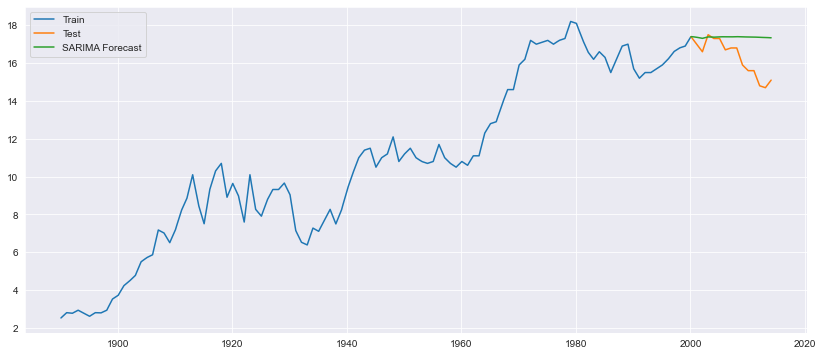

In [82]:
plt.figure(figsize=(14,6))
plt.plot(train_data['CO2'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

##### We can see that we are able to capture the trend and seasonality both.

### Model Evaluation

### Training Error

In [83]:
train_sarima  = sarima_model_fit.fittedvalues
train_rmse_sarima  = sqrt(mean_squared_error(train_sarima ,train_data))
train_rmse_sarima

0.07375065665500638

### Testing Error

#### RMSE (Root Mean Squared Error)

In [84]:
rmse_SARIMA = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_SARIMA

1.36

#### MAPE (Mean Absolute Percent Error)

In [85]:
mape_sarima = round(np.mean(np.abs((test_data.CO2 - y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data.CO2)*100),2)
mape_sarima

6.65

#### Observation:
1. SARIMA method has done reasonably well as it captures seasonality.
2. The performance is comparable with the other methods such as Holt's Winter additive/multiplicative, whcich also captures seasonality. |

### Analysing the Residuals

##### The mean of the Residual should be zero or close to Zero

In [86]:
model_residual = sarima_model_fit.resid
model_residual.mean()

0.0034813968797986774

#### Residuals must be stationary

In [87]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


#### No autocorrelation between residuals

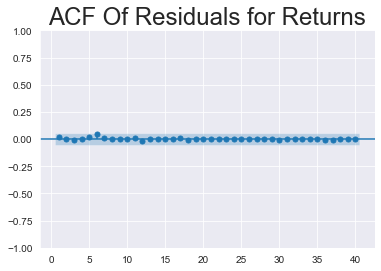

In [88]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

#### Residuals must be random

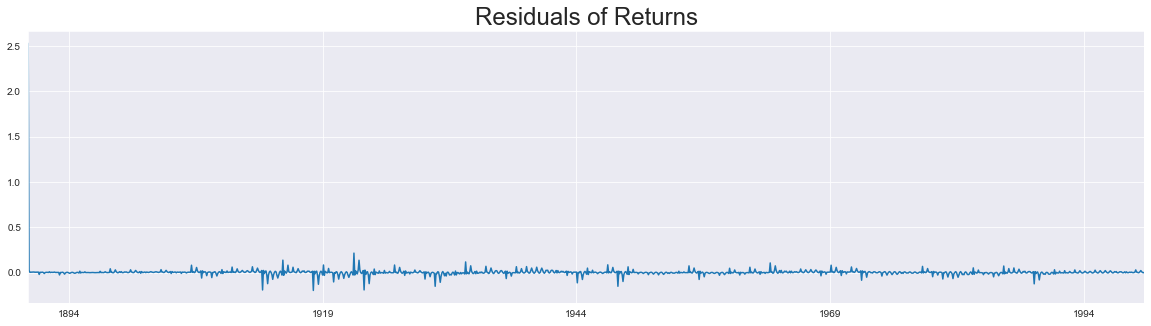

In [89]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

#### Creating model with differente Transformation Technique

In [90]:
#Compareing the results 

Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_additive","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_multiplicative","ARIMA","SARIMA"]),\
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_arima,mape_sarima]),\
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_ARIMA,rmse_SARIMA])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

Models    MAPE(%)  RMSE_Values
0                      ARIMA   2.511000     0.451000
1         Simple_Exponential   6.584042     1.357028
2                     SARIMA   6.650000     1.360000
3          Triple_Exp_mul_ad  28.181885     5.253746
4         Double_Exponential  28.905505     5.384533
5        Triple_Exp_additive  28.930162     5.388985
6  Triple_Exp_multiplicative  31.022272     5.846119
7          Triple_Exp_ad_mul  32.117831     6.050709

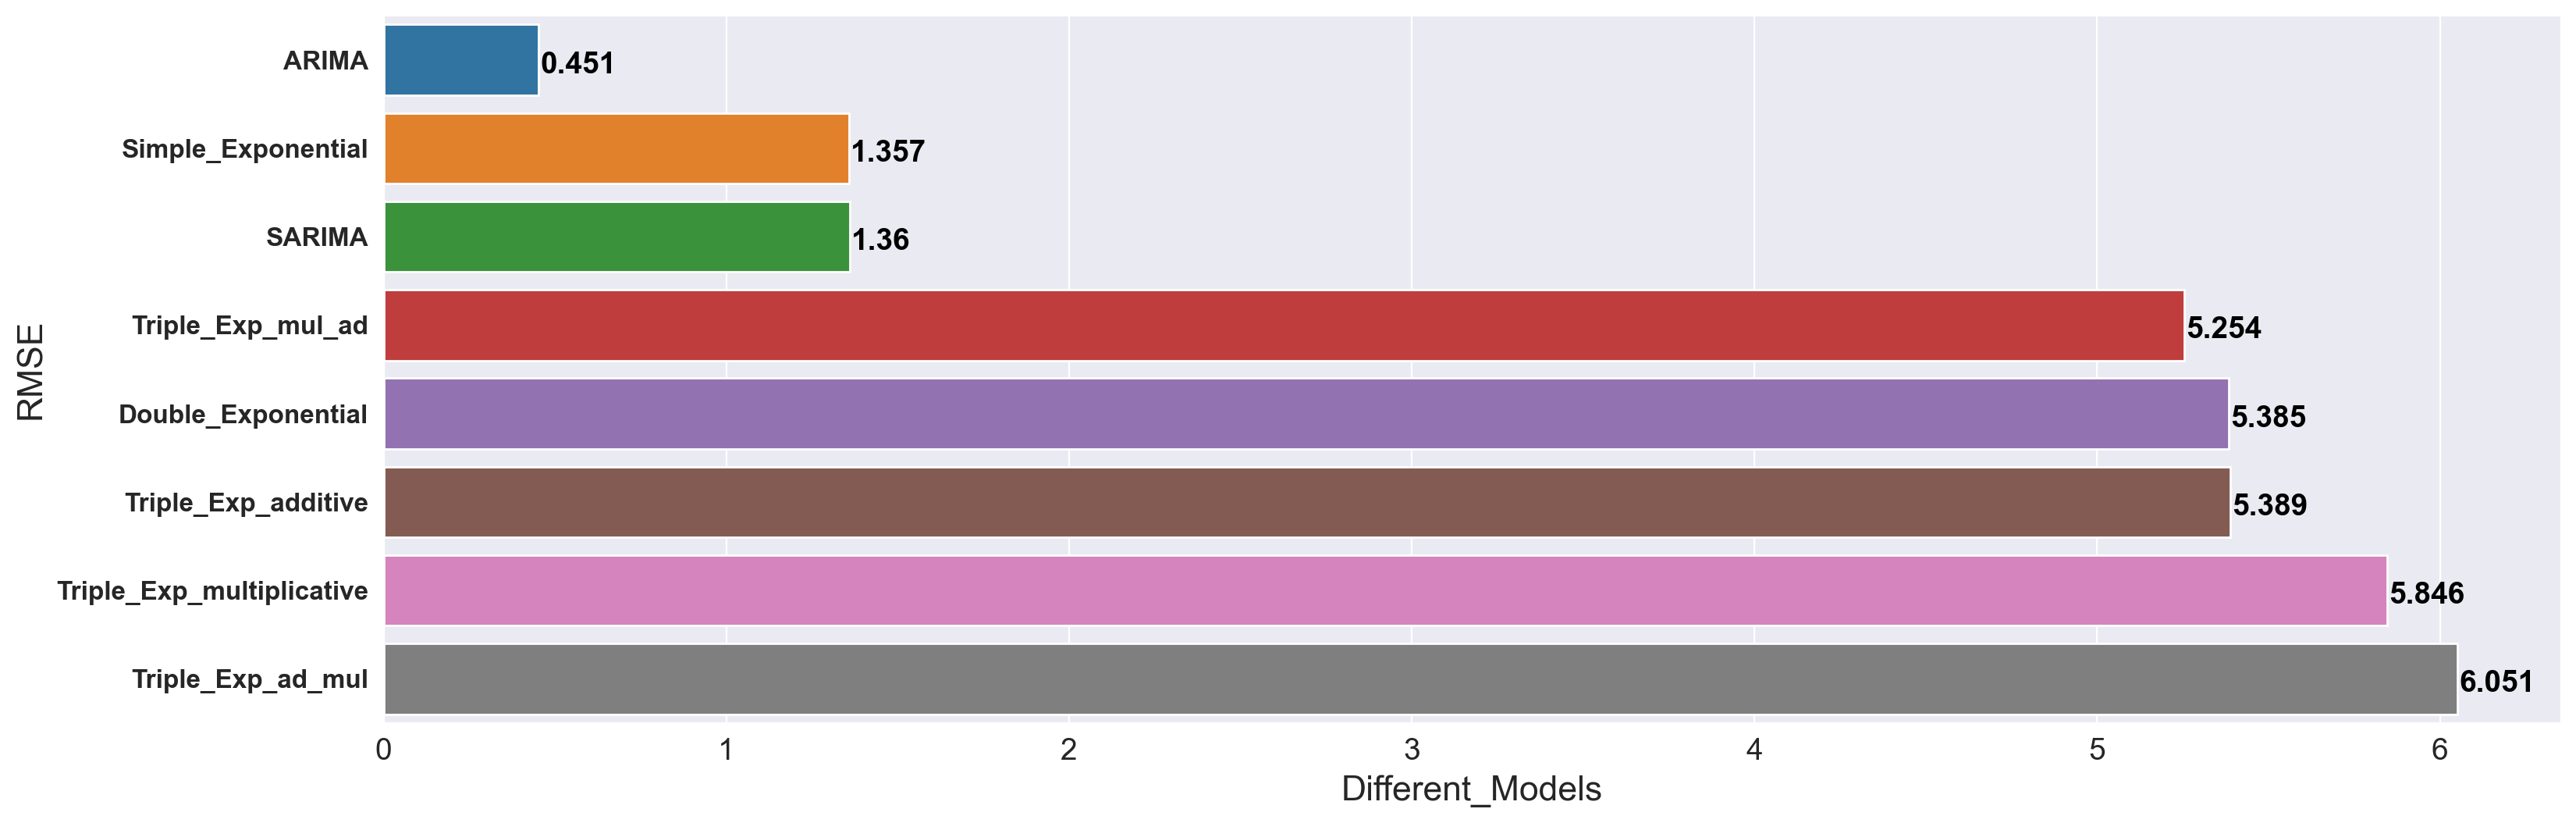

In [91]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=200)
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,3)):
    axe.text(v + 0.005, i + .15, str(v),
            color = 'black', fontweight = 'bold', fontsize= 14)

plt.show()

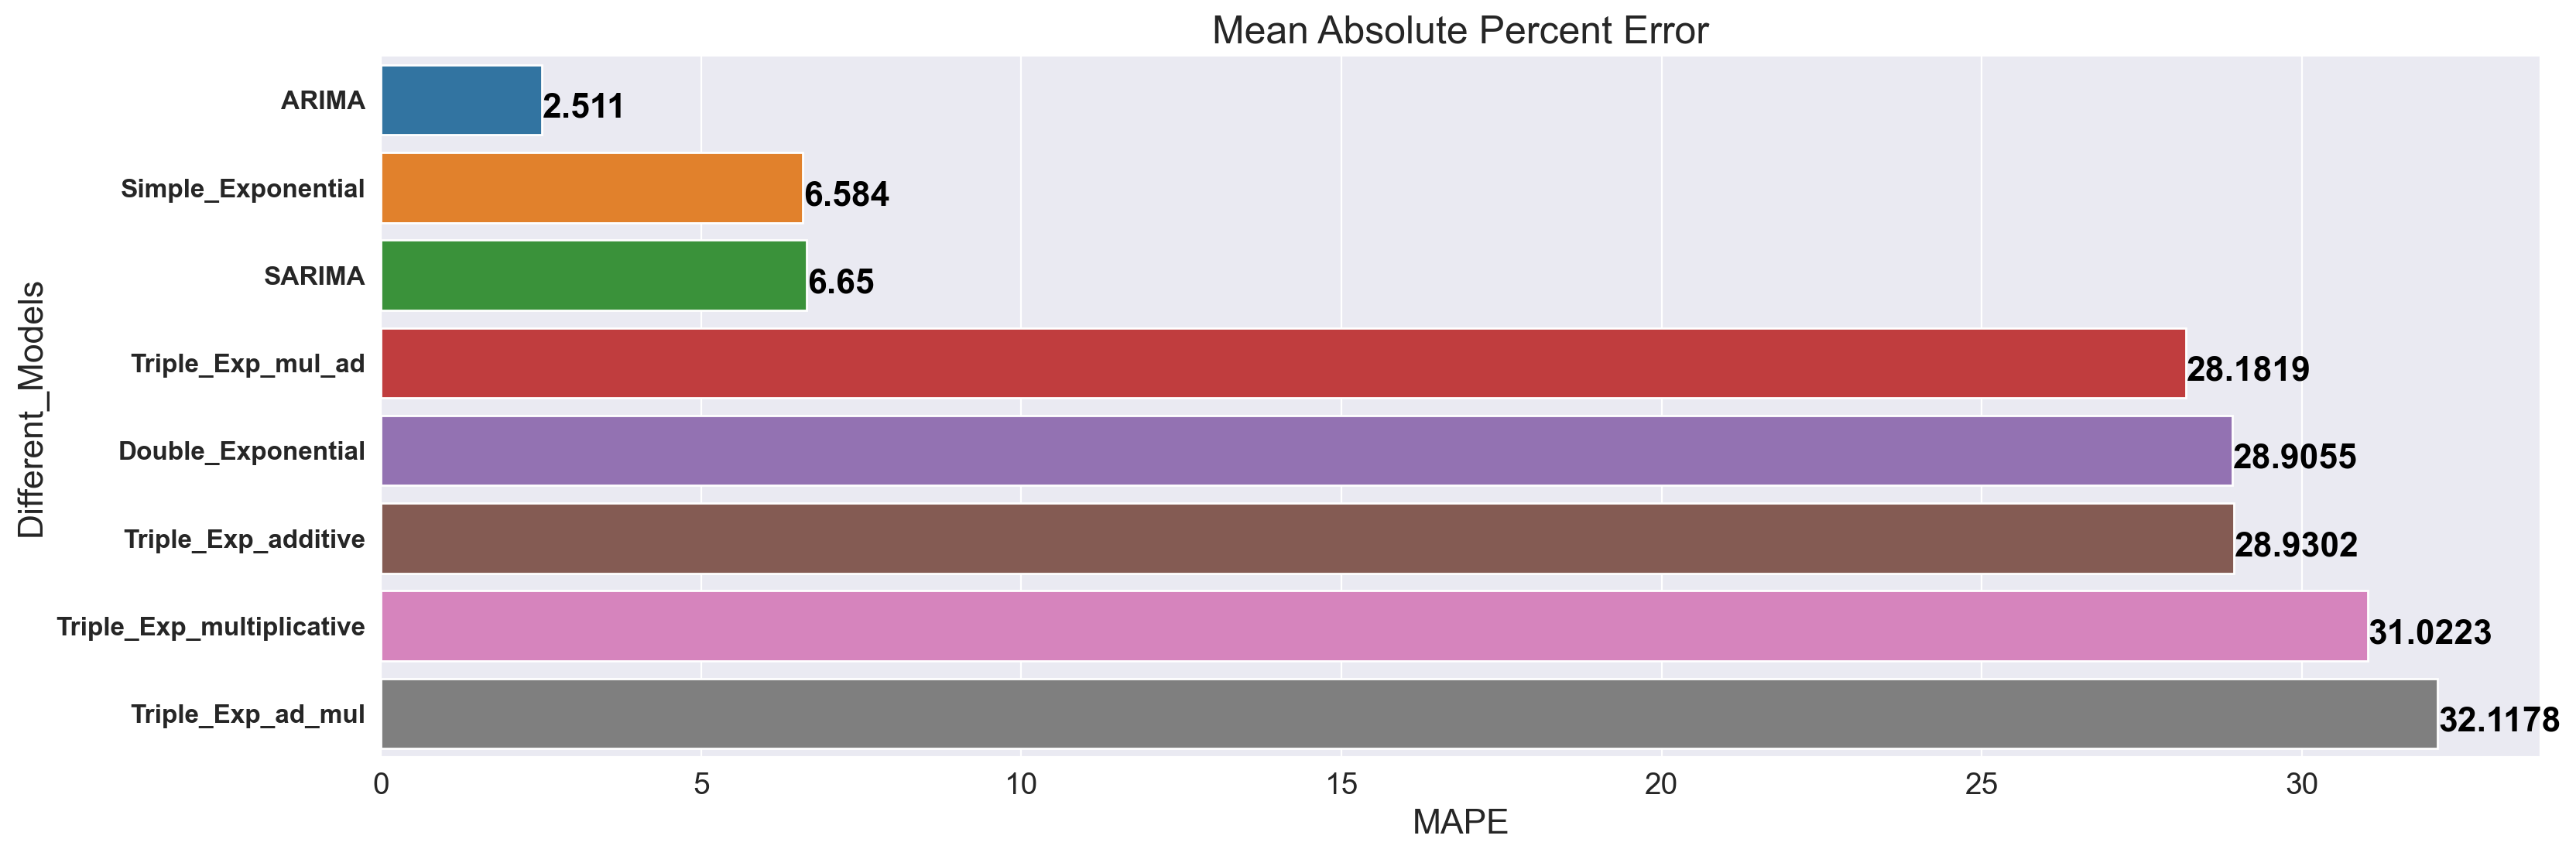

In [92]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=200)
sns.barplot(x='MAPE(%)', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('MAPE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.title("Mean Absolute Percent Error", fontsize = 18)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation['MAPE(%)'].values,4)):
    axe.text(v + 0.01, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

#### Observation:
+ **The Sarima Model did not performed very well as compared to other Models but Simple Exponential Smoothing better** 
+ **Note:Sarima with Hyperparameter tuning may get better results**
+ **Even in models such as ARIMA with hyperparameter tuning gave the best restult in this case**

#### Conclusion:
## <p style="color:black;font-size:18;">ARIMA:</p><p style="color:black;font-size:14px;">The best model we have got so far with the lowest RMSE and lowest MAPE.</p>    

### Forecasting Future Values Using ARIMA Model

#### Forecasting 5 years of data using the complete Data set

In [8]:
%matplotlib inline

In [93]:
df.shape

(1489, 1)

In [94]:
1489+60

1549

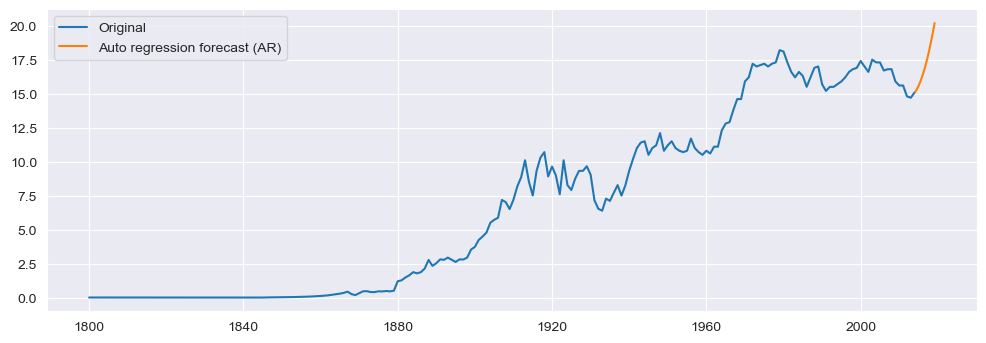

In [95]:
final_model = ARIMA(df, order=(5, 3, 1))
final_model_fit = final_model.fit()
forecast = pd.DataFrame()
forecast['arima_forecast'] = final_model_fit.predict(start = 1489, end = 1549)

plt.figure(figsize=(12,4), dpi=100)
plt.plot(data['CO2'], label='Original')
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

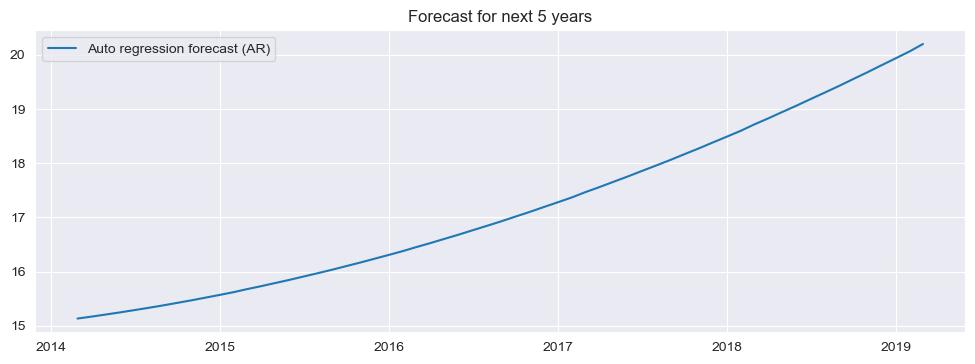

In [96]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.title('Forecast for next 5 years')
plt.legend(loc='best')
plt.show()

In [204]:
forecast

arima_forecast
2014-02-28       15.124414
2014-03-31       15.151952
2014-04-30       15.186944
2014-05-31       15.225139
2014-06-30       15.257040
...                    ...
2018-10-31       21.304195
2018-11-30       21.530950
2018-12-31       21.762527
2019-01-31       21.999357
2019-02-28       22.241986

[61 rows x 1 columns]

In [203]:
2569+120

2689

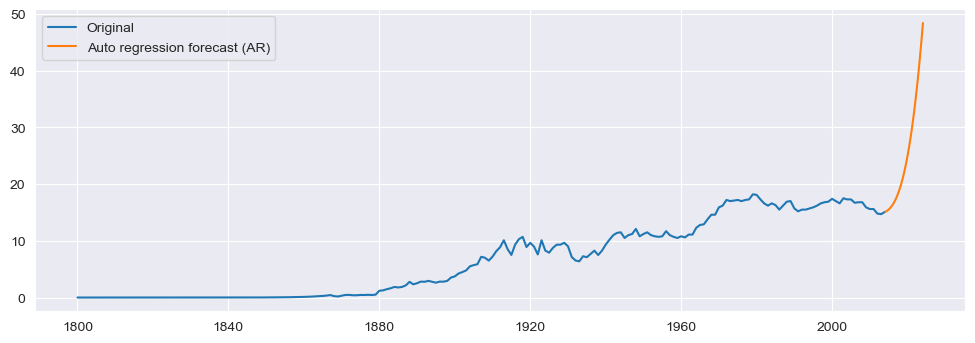

In [205]:
final_model = ARIMA(interpolated_month, order=(6, 4, 7))
final_model_fit = final_model.fit()
forecast = pd.DataFrame()
forecast['arima_forecast'] = final_model_fit.forecast(120)

plt.figure(figsize=(12,4), dpi=100)
plt.plot(data['CO2'], label='Original')
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

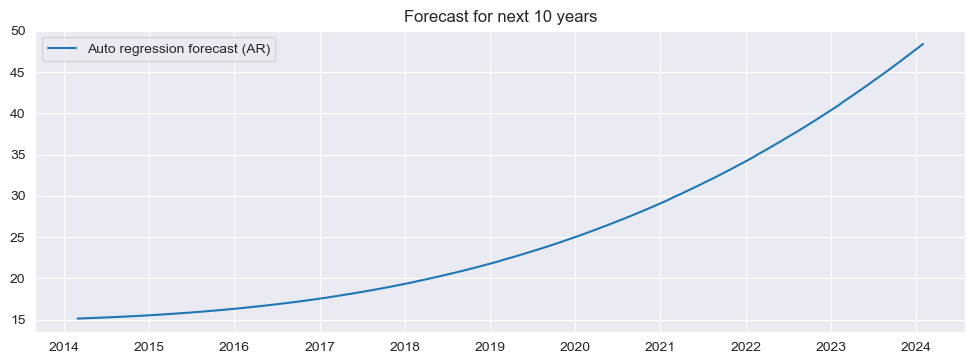

In [206]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.title('Forecast for next 10 years')
plt.legend(loc='best')
plt.show()

In [207]:
forecast

arima_forecast
2014-02-28       15.124414
2014-03-31       15.151952
2014-04-30       15.186944
2014-05-31       15.225139
2014-06-30       15.257040
...                    ...
2023-09-30       45.750608
2023-10-31       46.396366
2023-11-30       47.051104
2023-12-31       47.714914
2024-01-31       48.387849

[120 rows x 1 columns]

## Links for the repositories

<div style="display:fill;
            border-radius: false;
            border-style: solid;
            border-color:#000000;
            border-style: false;
            border-width: 2px;
            color:#CF673A;
            font-size:15px;
            font-family: Georgia;
            background-color:#E8DCCC;
            text-align:center;
            letter-spacing:0.1px;
            padding: 0.1em;">

**<h2>♡ Thank you for taking the time ♡**